<a href="https://colab.research.google.com/github/zachary-obrien/facial-keypoint-detection/blob/main/FacialLandmarks_Summer_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
#tf.enable_eager_execution()

im_300W_builder = tfds.builder('the300w_lp')
im_300W_builder.download_and_prepare()

Shuffling and writing examples to /root/tensorflow_datasets/the300w_lp/1.0.0.incompleteQP8HQ7/the300w_lp-train.tfrecord


Dataset the300w_lp downloaded and prepared to /root/tensorflow_datasets/the300w_lp/1.0.0. Subsequent calls will reuse this data.


In [3]:
%rm -rf /root/temp_data/train/
%rm -rf /root/temp_data/test/
%rm -rf /root/temp_data/validation/

%mkdir /root/temp_data/
%mkdir /root/temp_data/train/
%mkdir /root/temp_data/test/
%mkdir /root/temp_data/validation/

In [4]:
%mkdir /root/temp_data/models/

In [5]:
base_folder = "/root/temp_data/"
training_folder = "/root/temp_data/train/"
testing_folder = "/root/temp_data/test/"
validation_folder = "/root/temp_data/validation/"

In [6]:
IMAGE_SHAPE = [450, 450, 3]
BATCH_SIZE = 32
NUM_EPOCHS = 10

IMAGE_SIZE_SQUARE = 450
DOWNSCALE_TO = 112
# DOWNSCALE_TO = int(IMAGE_SIZE_SQUARE / 4)

PERCENT_TRAIN = 70
PERCENT_TEST = 20
PERCENT_VALIDATION = 10
if (PERCENT_TRAIN + PERCENT_TEST + PERCENT_VALIDATION) != 100:
  raise

TEST_OFFSET = PERCENT_TRAIN + PERCENT_TEST

training_json = {"ids": [],
                 "batch_size": BATCH_SIZE, 
                 "image_shape": IMAGE_SHAPE}
testing_json = {"ids": [],
                 "batch_size": BATCH_SIZE, 
                 "image_shape": IMAGE_SHAPE}
validation_json = {"ids": [],
                 "batch_size": BATCH_SIZE, 
                 "image_shape": IMAGE_SHAPE}

In [7]:
#ds = tfds.load('the300w_lp', split='train', shuffle_files=True)

(training_set, testing_set, validation_set), dataset_info = tfds.load(
    'the300w_lp',
    split=[ 'train[:{:d}%]'.format(PERCENT_TRAIN), 'train[{:d}:{:d}%]'.format(PERCENT_TRAIN, TEST_OFFSET), 'train[{:d}%:]'.format(TEST_OFFSET)],
    with_info=True,
    
)

steps_per_epoch = int(len(training_set) // BATCH_SIZE)
validation_steps = int(len(testing_set) // BATCH_SIZE)

In [8]:
from PIL import Image, ImageEnhance
import random

# https://pillow.readthedocs.io/en/stable/reference/ImageEnhance.html
def alter_brightness(image):
  enhancer = ImageEnhance.Brightness(image)
  factor = random.random() + 0.5
  im_output = enhancer.enhance(factor)

  return im_output


# https://pillow.readthedocs.io/en/stable/reference/ImageEnhance.html
def alter_contrast(image):
  enhancer = ImageEnhance.Contrast(image)
  factor = random.random() + 0.5
  im_output = enhancer.enhance(factor)

  return im_output

# https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=transpose#transpose-methods
def alter_flip(image, width, keypoints):
  im_output = image.transpose(Image.FLIP_LEFT_RIGHT)
  print(keypoints.shape)
  print(keypoints)
  for index in range(0, len(keypoints)):
    keypoints[index][0] = width - keypoints[index][0]

  return im_output, keypoints

# https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def alter_noise(image, width, height, noise_type=None):
  image = np.array(image.convert('L'))
  image = np.expand_dims(image, axis=-1)
  noise_list = ["gauss", "s&p", "poisson"]
  if not noise_type:
    noise_type = random.choice(noise_list)


  out_img = None
  if noise_type == "gauss":
    # image=np.array (image/255, dtype=float)
    image=np.array (image/width, dtype=float)
    row,col,ch= image.shape
    mean = 0.1
    var = 0.001
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    out = image + gauss
    if out.min ()<0:
      low_clip = -1.
    else:
      low_clip = 0.
    out = np.clip (out, low_clip, 1.0)
    # out=np.uint8 (out * 255)
    out=np.uint8 (out * width)
    out_img = out
  elif noise_type == "s&p":
    prob = 0.01
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    out_img = output
  elif noise_type == "poisson":
    # image=np.array (image/255, dtype=float)
    image=np.array (image/width, dtype=float)
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    # noisy=np.uint8 (noisy * 255)
    noisy=np.uint8 (noisy * width)
    out_img = noisy

  tmp_img = np.zeros((width, height, 1))
  tmp_img[:out_img.shape[0],:out_img.shape[1]] = out_img
  tmp_img = np.concatenate([out_img, out_img, out_img], axis=2).astype(np.uint8)
  tmp_img = Image.fromarray(tmp_img)
  return tmp_img

In [9]:
import numpy as np
from PIL import Image
import numpy as np
%matplotlib inline

def save_images_and_keypoints(input_dataset, folder_name, index=0, brightness=False, contrast=False, noise=False, image_width=450, image_height=450):
  image_names = []
  keypoint_names = []
  for element in input_dataset:
    index += 1
    if index % 100 == 0:
      print(str(index), " records processed")
    # Get Keypoints
    keypoints = element['landmarks_2d']
    keypoints = keypoints * image_width
    keypoint_write = []
    for point in keypoints:
      point = point.numpy()
      x = int(point[0])
      y = int(point[1])
      # TODO: Didn't actually have to flip the points. Done in the generator
      # refactor this to just use keypoints instead of looping
      keypoint_write.append([x, y])

    numpy_write = np.array(keypoint_write)

    # Get image
    element_image = element['image']
    element_image = element_image.numpy()
    element_image = np.asarray(element_image)
    im = Image.fromarray(element_image)

    # random_mutation = random.randint(1, 10)
    random_mutation = 0

    if brightness or random_mutation == 1:
      img_brightness = alter_brightness(im)

      bright_filename = folder_name + "{:d}_brightness.jpg".format(index)
      img_brightness.save(bright_filename)
      image_names.append(bright_filename)
      
      bright_npy = folder_name + "{:d}_brightness.npy".format(index)
      np.save(file=bright_npy, arr=numpy_write, allow_pickle=False)
      keypoint_names.append(bright_npy)

    elif contrast or random_mutation == 2:
      img_contrast = alter_contrast(im)

      contrast_filename = folder_name + "{:d}_contrast.jpg".format(index)
      img_contrast.save(contrast_filename)
      image_names.append(contrast_filename)

      contrast_npy = folder_name + "{:d}_contrast.npy".format(index)
      np.save(file=contrast_npy, arr=numpy_write, allow_pickle=False)
      keypoint_names.append(contrast_npy)

    # ["gauss", "s&p", "poisson"]
    elif noise or random_mutation in [3, 4, 5]:
      noise_type = random.choice(["gauss", "s&p", "poisson"])
      img_noise = alter_noise(im, image_width, image_height, noise_type=noise_type)

      noise_filename = folder_name + "{:d}_noise.jpg".format(index)
      img_noise.save(noise_filename)
      image_names.append(noise_filename)

      noise_npy = folder_name + "{:d}_noise.npy".format(index)
      np.save(file=noise_npy, arr=numpy_write, allow_pickle=False)
      keypoint_names.append(noise_npy)

    image_filename = folder_name + "{:d}.jpg".format(index)
    im.save(image_filename)
    image_names.append(image_filename)

    keypoint_filename = folder_name + "{:d}.npy".format(index)
    np.save(file=keypoint_filename, arr=numpy_write, allow_pickle=False)
    keypoint_names.append(keypoint_filename)
    
  return image_names, keypoint_names



In [10]:
import json

training_images, training_keypoints = save_images_and_keypoints(training_set, training_folder)
for file_base in training_images:
    file_base = file_base.replace(".jpg", "")
    training_json['ids'].append(file_base)
with open(base_folder + 'train_params.json', 'w') as fp:
    json.dump(training_json, fp)
print(training_images[0])
print(training_keypoints[0])
print(training_json['ids'][0])

100  records processed
200  records processed
300  records processed
400  records processed
500  records processed
600  records processed
700  records processed
800  records processed
900  records processed
1000  records processed
1100  records processed
1200  records processed
1300  records processed
1400  records processed
1500  records processed
1600  records processed
1700  records processed
1800  records processed
1900  records processed
2000  records processed
2100  records processed
2200  records processed
2300  records processed
2400  records processed
2500  records processed
2600  records processed
2700  records processed
2800  records processed
2900  records processed
3000  records processed
3100  records processed
3200  records processed
3300  records processed
3400  records processed
3500  records processed
3600  records processed
3700  records processed
3800  records processed
3900  records processed
4000  records processed
4100  records processed
4200  records processed
4

In [11]:
import json

testing_images, testing_keypoints = save_images_and_keypoints(testing_set, testing_folder, len(training_images))
for file_base in testing_images:
    file_base = file_base.replace(".jpg", "")
    testing_json['ids'].append(file_base)
with open(base_folder + 'test_params.json', 'w') as fp:
    json.dump(testing_json, fp)
print(testing_images[0])
print(testing_keypoints[0])
print(testing_json['ids'][0])

42900  records processed
43000  records processed
43100  records processed
43200  records processed
43300  records processed
43400  records processed
43500  records processed
43600  records processed
43700  records processed
43800  records processed
43900  records processed
44000  records processed
44100  records processed
44200  records processed
44300  records processed
44400  records processed
44500  records processed
44600  records processed
44700  records processed
44800  records processed
44900  records processed
45000  records processed
45100  records processed
45200  records processed
45300  records processed
45400  records processed
45500  records processed
45600  records processed
45700  records processed
45800  records processed
45900  records processed
46000  records processed
46100  records processed
46200  records processed
46300  records processed
46400  records processed
46500  records processed
46600  records processed
46700  records processed
46800  records processed


In [12]:
import json

validation_images, validation_keypoints = save_images_and_keypoints(validation_set, validation_folder, (len(training_images) + len(testing_images)))
for file_base in validation_images:
    file_base = file_base.replace(".jpg", "")
    validation_json['ids'].append(file_base)
with open(base_folder + 'validation_params.json', 'w') as fp:
    json.dump(validation_json, fp)
print(validation_images[0])
print(validation_keypoints[0])
print(validation_json['ids'][0])

55200  records processed
55300  records processed
55400  records processed
55500  records processed
55600  records processed
55700  records processed
55800  records processed
55900  records processed
56000  records processed
56100  records processed
56200  records processed
56300  records processed
56400  records processed
56500  records processed
56600  records processed
56700  records processed
56800  records processed
56900  records processed
57000  records processed
57100  records processed
57200  records processed
57300  records processed
57400  records processed
57500  records processed
57600  records processed
57700  records processed
57800  records processed
57900  records processed
58000  records processed
58100  records processed
58200  records processed
58300  records processed
58400  records processed
58500  records processed
58600  records processed
58700  records processed
58800  records processed
58900  records processed
59000  records processed
59100  records processed


In [13]:
def add_keypoints_to_image(image, keypoints):
  for point in keypoints:
    x = int(point[0])
    y = int(point[1])
    image[y][x] = (0, 255, 0)
    image[y-1][x] = (0, 255, 0)
    image[y-2][x] = (0, 255, 0)
    image[y-3][x] = (0, 255, 0)
    image[y+1][x] = (0, 255, 0)
    image[y+2][x] = (0, 255, 0)
    image[y+3][x] = (0, 255, 0)
    image[y][x-1] = (0, 255, 0)
    image[y][x-2] = (0, 255, 0)
    image[y][x-3] = (0, 255, 0)
    image[y][x+1] = (0, 255, 0)
    image[y][x+2] = (0, 255, 0)
    image[y][x+3] = (0, 255, 0)

  return image

In [14]:
from matplotlib.pyplot import imshow

def visualize_data(image_number, folder):
  im_copy = None

  with Image.open(folder + str(image_number) + ".jpg") as im:
    tmp = im.copy()
    tmp = np.asarray(tmp)
    im_copy = np.empty_like(tmp)
    im_copy[:] = tmp

  keypoints = np.load(folder + str(image_number) + ".npy")
  keypoint_image = add_keypoints_to_image(im_copy, keypoints)
  imshow(keypoint_image)
  return keypoint_image, keypoints

/root/temp_data/train/


(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[147, 281],
        [147, 300],
        [153, 318],
        [162, 337],
        [171, 359],
        [183, 376],
        [192, 382],
        [19

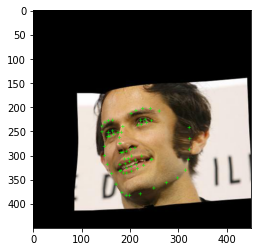

In [15]:
print(training_folder)
visualize_data(1, training_folder)

/root/temp_data/test/


(array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[  7,   0,   0],
         [  5,   0,   0],
         [  1,   1,   1],
         ...,
         [216, 178, 141],
         [214, 175, 142],
         [207, 168, 135]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [210, 175, 135],
         [212, 172, 137],
         [212, 172, 137]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [210, 175, 135],
  

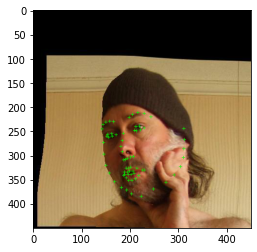

In [17]:
print(testing_folder)
visualize_data(54600, testing_folder)

/root/temp_data/validation/


(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[127, 251],
        [130, 277],
        [136, 300],
        [143, 321],
        [154, 341],
        [171, 358],
        [191, 368],
        [21

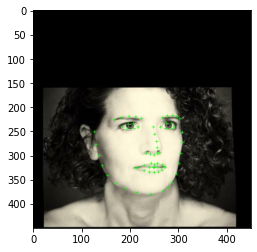

In [18]:
print(validation_folder)
visualize_data(60900, validation_folder)

In [19]:
# Actual structure of the model. 
# Based on the whitepaper : https://arxiv.org/abs/1603.06937
# Based on code for pose estimation found here: https://github.com/ethanyanjiali/deep-vision/tree/master/Hourglass/tensorflow
# Adapted for facial landmark detection
import tensorflow as tf

from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    ReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)

def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,  # lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
    # Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1


def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


def StackedHourglassNetwork(
        input_shape=(450, 450, 3), num_stack=4, num_residual=1,
        num_heatmap=68):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

    # initial processing of the image
    x = Conv2D(
        filters=32,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # predict 128 channels like a fully connected layer.
        x = LinearLayer(x, 256)

        # predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # if it's not the last stack, we need to add predictions back
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [20]:
from tensorflow.math import pow, log, abs, cumsum, reduce_sum, greater, reduce_mean
# This is a heatmap specific loss function that helps with heatmaps.
# MSE has too many zeros being output and the gradient gets too small to matter.
# Whitepaper: https://arxiv.org/pdf/1904.07399v3.pdf
# Code: https://github.com/andrewhou1/Adaptive-Wing-Loss-for-Face-Alignment/blob/master/hourglasstensorflow/hourglass_tiny.py
def adaptive_wing_loss(labels, output):
    alpha = 2.1
    omega = 14
    epsilon = 1
    theta = 0.5
    with tf.name_scope('adaptive_wing_loss'):
        x = output - labels
        theta_over_epsilon_tensor = tf.fill(tf.shape(labels), theta/epsilon)
        A = omega*(1/(1+pow(theta_over_epsilon_tensor, alpha-labels)))*(alpha-labels)*pow(theta_over_epsilon_tensor, alpha-labels-1)*(1/epsilon)
        C = theta*A-omega*log(1+pow(theta_over_epsilon_tensor, alpha-labels))
        absolute_x = abs(x)
        losses = tf.where(greater(theta, absolute_x), omega*log(1+pow(absolute_x/epsilon, alpha-labels)), A*absolute_x-C)
        loss = reduce_mean(reduce_sum(losses, axis=[1, 2]), axis=0)
        return loss

In [21]:
# plots literal xy coordinates on the given image
def plot_literal_points(data, points, show=True):
    size = len(data) - 1
    color = (0,255,255)
    h = size
    w = len(data[0]) - 1
    
    for x, y in points:
        #x = int(xr * w)
        #y = int(yr * h)
        x = int(x)
        y = int(y)
        
        x = max(x, 0)
        x = min(x, w - 1)
        y = max(y, 0)
        y = min(y, h-1)
        
        data[y][x] = color

        if y > 0:
            data[y-1][x] = color
        if x > 0:
            data[y][x-1] = color
        if x < w:
            data[y][x+1] = color
        if y < h:
            data[y+1][x] = color
    if show:
        imshow(data.astype(np.uint8))

# plots the normalized (0 to 1) coordinates on the given image
def plot_keypoints(data, points, show=True):
    size = len(data) - 1
    color = (0,255,0)
    h = size
    w = len(data[0]) - 1
    
    for xr, yr in points:
        x = int(xr * w)
        y = int(yr * h)
        
        x = max(x, 0)
        x = min(x, w - 1)
        y = max(y, 0)
        y = min(y, h-1)
        
        data[y][x] = color

        if y > 0:
            data[y-1][x] = color
        if x > 0:
            data[y][x-1] = color
        if x < w:
            data[y][x+1] = color
        if y < h:
            data[y+1][x] = color
    if show:
        imshow(data.astype(np.uint8))

In [22]:
import keras
"""
    generator that loads and augments batches of images for training
    imgaug handles augmenting the images and their corresponding keypoints
"""
class train_generator(keras.utils.Sequence):
    def __init__(self):
        # the parameters are saved and loaded from a json because tf
        # requires the generator to be instantiated with zero arguments
        # in order to convert it to a tf.dataset
        with open(base_folder + 'train_params.json') as f:
            params = json.load(f)
        self.ids = params['ids']
        self.batch_size = params['batch_size']
        self.image_shape = params['image_shape']
        self.downscaling = 450/DOWNSCALE_TO

        # image augmentation pipeline
        # self.aug = iaa.Sequential([
        #     #iaa.CropToAspectRatio(1),
        #     iaa.Resize({"height": 128, "width": 128}),
        #     iaa.Affine(scale=(0.7, 1.3), rotate=(-40, 40))])
        
        # constants used to create the gaussian heatmaps for the labels
        self.x = np.arange(0, DOWNSCALE_TO, 1, float) ## (width,)
        self.y = np.arange(0, DOWNSCALE_TO, 1, float)[:, np.newaxis] ## (height,1)
        
    def __len__(self) :
        return (np.ceil(len(self.ids) / float(self.batch_size))).astype(np.int)

    # for some reason tf was saying that the generators were running out before
    # they were supposed to when using interleave so I just made this function loop infinitely
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        while 1:
            for item in (self[i] for i in range(len(self))):
                yield item

    # loads the image and the corresponding labels
    def load(self, base_name):
        img = np.asarray(Image.open(base_name + '.jpg'))
        return (img, np.load(base_name + '.npy', allow_pickle=True))

    # these next four functions are for creating the gaussian heatmaps from
    # the batch of coordinate labels
    def xy_to_heatmap(self, xy):
        mean = [int(xy[1] / self.downscaling), int(xy[0] / self.downscaling)]
        #print('{} -> {}'.format([xy[1], xy[0]], mean))

        pos = np.dstack(np.mgrid[0:DOWNSCALE_TO:1, 0:DOWNSCALE_TO:1])
        rv = multivariate_normal(mean=mean, cov=4)

        return rv.pdf(pos)
    
    def gaussian_k(self, x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        return np.exp(-((self.x-x0)**2 + (self.y-y0)**2) / (2*sigma**2))

    def generate_hm(self, height, width ,landmarks,s=3):
        """ Generate a full Heap Map for every landmarks in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
            joints    : [(x1,y1),(x2,y2)...] containing landmarks
            maxlenght : Lenght of the Bounding Box
        """

        Nlandmarks = len(landmarks)
        hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
        for i in range(Nlandmarks):
            if not np.array_equal(landmarks[i], [-1,-1]):
            
                hm[:,:,i] = self.gaussian_k(landmarks[i][0],
                                        landmarks[i][1],
                                        s,height, width)
            else:
                hm[:,:,i] = np.zeros((height,width))
        return hm

    def get_y_as_heatmap(self, kps,height,width, sigma):
        y_train = []
        for i in range(kps.shape[0]): 
            y_train.append(self.generate_hm(height, width, kps[i], sigma))

        y_train = np.array(y_train)
    
    
        return y_train

    # given a batch index loads the batch of images and keypoints, 
    # augments them, creates the heatmaps and returns the batch of
    # images and heatmaps
    def __getitem__(self,idx):
        batch_ids = self.ids[idx * self.batch_size : (idx+1) * self.batch_size]
        files = list(map(self.load, batch_ids))
        batch_x = [tup[0] for tup in files]
        batch_y = [tup[1] for tup in files]

        #batch_x, batch_y = self.aug(images=batch_x, keypoints=batch_y)
        
        batch_y = np.array(batch_y)
        batch_y = batch_y / self.downscaling
        batch_y = self.get_y_as_heatmap(batch_y, DOWNSCALE_TO, DOWNSCALE_TO, 2)
        
        return np.asarray(batch_x), batch_y


In [23]:
import keras
# Same as the train generator, but loads different parameters
# and does less augmentation (just crops and resizes to fit model)
class val_generator(keras.utils.Sequence):
    def __init__(self):
        with open(base_folder + 'test_params.json') as f:
            params = json.load(f)
        self.ids = params['ids']
        self.batch_size = params['batch_size']
        self.image_shape = params['image_shape']
        self.downscaling = 450/DOWNSCALE_TO
        # self.aug = iaa.Sequential([
        #     #iaa.CropToAspectRatio(1),
        #     iaa.Resize({"height": 256, "width": 256})])
        
        self.x = np.arange(0, DOWNSCALE_TO, 1, float) ## (width,)
        self.y = np.arange(0, DOWNSCALE_TO, 1, float)[:, np.newaxis] ## (height,1)
        

    def __len__(self) :
        return (np.ceil(len(self.ids) / float(self.batch_size))).astype(np.int)
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        while 1:
            for item in (self[i] for i in range(len(self))):
                yield item
    def xy_to_heatmap(self, xy):
        mean = [int(xy[1] / self.downscaling), int(xy[0] / self.downscaling)]
        #print('{} -> {}'.format([xy[1], xy[0]], mean))

        pos = np.dstack(np.mgrid[0:DOWNSCALE_TO:1, 0:DOWNSCALE_TO:1])
        rv = multivariate_normal(mean=mean, cov=4)

        return rv.pdf(pos)
    
    def load(self, num):
        # img = Image.open(num + '.png')
        # if type(img.getpixel((0,0))) == int:
        #     rgbimg = Image.new("RGB", img.size)
        #     rgbimg.paste(img)
        #     img = rgbimg
        # img = np.asarray(img)
        img = np.asarray(Image.open(num + '.jpg'))
        return (img, np.load(num + '.npy', allow_pickle=True))


    def gaussian_k(self, x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        return np.exp(-((self.x-x0)**2 + (self.y-y0)**2) / (2*sigma**2))

    def generate_hm(self, height, width ,landmarks,s=3):
        """ Generate a full Heap Map for every landmarks in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
            joints    : [(x1,y1),(x2,y2)...] containing landmarks
            maxlenght : Lenght of the Bounding Box
        """

        Nlandmarks = len(landmarks)
        hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
        for i in range(Nlandmarks):
            if not np.array_equal(landmarks[i], [-1,-1]):
            
                hm[:,:,i] = self.gaussian_k(landmarks[i][0],
                                        landmarks[i][1],
                                        s,height, width)
            else:
                hm[:,:,i] = np.zeros((height,width))
        return hm

    def get_y_as_heatmap(self, kps,height,width, sigma):
        y_train = []
        for i in range(kps.shape[0]): 
            y_train.append(self.generate_hm(height, width, kps[i], sigma))

        y_train = np.array(y_train)
    
    
        return y_train

    def __getitem__(self,idx):
        batch_ids = self.ids[idx * self.batch_size : (idx+1) * self.batch_size]
        files = list(map(self.load, batch_ids))
        batch_x = [tup[0] for tup in files]
        batch_y = [tup[1] for tup in files]

        #batch_x, batch_y = self.aug(images=batch_x, keypoints=batch_y)
        
        batch_y = np.array(batch_y)
        batch_y = batch_y / self.downscaling
        batch_y = self.get_y_as_heatmap(batch_y, DOWNSCALE_TO, DOWNSCALE_TO, 2)
        return np.asarray(batch_x), batch_y


In [24]:
# loader functions for the generators needed by tensorflow
# in order to use interleave   
def get_train_dataset(self):
    self = tf.data.Dataset.from_generator(
        train_generator,
        output_types = (tf.float32, tf.float32))
    return self

In [25]:
# loader functions for the generators needed by tensorflow
# in order to use interleave   
def get_val_dataset(self):
    self = tf.data.Dataset.from_generator(
        val_generator,
        output_types = (tf.float32, tf.float32))
    return self

In [26]:
# reduces the loss every n epochs
def scheduler(epoch, lr):
    n = 11

    if epoch > 1 and (epoch - 1) % n == 0:
        return lr - 5e-5
    else:
        return lr

In [27]:
# takes a list of heatmaps and returns a list of 
# keypoint coordinates
def heatmaps_to_keypoints(hms, num_keypoints=68):
    # max confidences and corresponding coordinates
    max_values = [0 for _ in range(num_keypoints)]
    max_xy = [[0,0] for _ in range(num_keypoints)]

    # find the coordinats of the pixel with the highest
    # value (confidence) from each heatmap
    for y in range(DOWNSCALE_TO):
        for x in range(DOWNSCALE_TO):
            for idx in range(num_keypoints):
                if hms[y][x][idx] > max_values[idx]:
                    max_values[idx] = hms[y][x][idx]
                    max_xy[idx] = [x, y]

    # normalize the keypoints from 0 to 1
    keypoints = []
    for i, xy in enumerate(max_xy):
        x, y = xy
        keypoints.append([x/DOWNSCALE_TO, y/DOWNSCALE_TO])
    
    return keypoints


In [28]:
from keras.metrics import RootMeanSquaredError

# the callbacks used during training
# lr scheduler, model checkpoint to save the weights after
# each record low validation loss, and the custom gifCallback
callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.ModelCheckpoint(
                base_folder + 'models/weights.40k_{epoch:02d}-{val_loss:.2f}.hdf5',
                monitor="val_loss",
                save_weights_only=True,
                verbose=1,
                save_best_only=True,
                mode="auto",
                save_freq="epoch",
            )]

# using RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(2.5e-4)
# create the stacked hourglass model with the given number
# of stacked hourglass modules
model = StackedHourglassNetwork(num_stack=2)
model.compile(optimizer=optimizer, loss=adaptive_wing_loss, metrics=['mae', 'mse', RootMeanSquaredError()])

# from each of the generators create a pair of interleaved datasets
# tensorflow can automatically multiprocess interleaved datasets
# so that while batches can be loaded and processed ahead of time
interleaved_train = tf.data.Dataset.range(2).interleave(
                    get_train_dataset,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE
                )
interleaved_val = tf.data.Dataset.range(2).interleave(
                    get_val_dataset,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE
                )

Instructions for updating:
Use output_signature instead


Instructions for updating:
Use output_signature instead


In [29]:
# train the model
model.fit(interleaved_train,
          steps_per_epoch = steps_per_epoch,
          epochs = NUM_EPOCHS,
          verbose = 1,
          validation_data = interleaved_val,
          validation_steps = validation_steps,
          callbacks = callbacks)

Epoch 1/10


ResourceExhaustedError: ignored

In [ ]:
model.save('/content/drive/MyDrive/facial-keypoints-detection/450_ip300w')


In [ ]:
print(validation_folder)
keypoint_image, keypoints = visualize_data(3, validation_folder)



In [ ]:
keypoint_image = np.asarray(Image.open(validation_folder + '3.jpg'))
keypoint_image, keypoint_data = (keypoint_image, np.load(validation_folder + '3.npy', allow_pickle=True))
print(keypoint_image.shape)
keypoint_image = np.expand_dims(keypoint_image, axis=0)
print(keypoint_image.shape)


In [ ]:
heatmap = model.predict(keypoint_image)

#heatmap = model.predict(img_pad)
output = np.asarray(heatmap)
kp1 = heatmaps_to_keypoints(heatmap[0][0])
kp1 = np.asarray(kp1)
kp1 = kp1*90*4
kp1 = np.rint(np.floor(kp1))

kp2 = heatmaps_to_keypoints(heatmap[1][0])
kp2 = np.asarray(kp2)
kp2 = kp2*90*4
kp2 = np.rint(np.floor(kp2))

kp = (kp1 + kp2) / 2

In [ ]:
print(kp1)

In [ ]:
print(type(keypoint_image))
# tmp = im.copy()
# tmp = np.asarray(tmp)
keypoint_image_copy = np.empty_like(keypoint_image)
keypoint_image_copy[:] = keypoint_image

print(keypoint_image_copy.shape)
keypoint_image_copy = np.squeeze(keypoint_image_copy, axis=0)
print(keypoint_image_copy.shape)
print(kp1.shape)
keypoint_image_copy = add_keypoints_to_image(keypoint_image_copy, kp1)
imshow(keypoint_image_copy)


In [ ]:
keypoint_image_copy = add_keypoints_to_image(keypoint_image_copy, kp2)
imshow(keypoint_image_copy)

In [ ]:
kp = (kp1 + kp2) / 2
keypoint_image_copy = add_keypoints_to_image(keypoint_image_copy, kp)
imshow(keypoint_image_copy)

In [ ]:
# # This is the final validation using the test data from the leaderboards. 
# # It uses the Root Mean Squared Error function defined above that gets run over the entire dataset
# # This was done for the contestants but I'll have to do this myself

# import pandas as pd

# validation_data = pd.read_csv('test.csv')

# for idx, sample in validation_data.iterrows():
#   print(sample)
#   image = np.array(sample['Image'].split(' '), dtype=int)
#   keypoint_data = sample.iloc[:30]
#   image = np.reshape(image, (96,96,1))

        
#   tmp_img = np.zeros((96, 96, 1))
#   tmp_img[:image.shape[0],:image.shape[1]] = image
#   tmp_img = np.concatenate([image, image, image], axis=2).astype(np.uint8)
#   tmp_img = Image.fromarray(tmp_img)
#   tmp_img = tmp_img.resize((256,256))
  
#   np_im = np.array(tmp_img.convert('L'))
#   img_pad = np.expand_dims(np_im, axis=-1)
#   img_pad = img_pad/255.

#   print(type(keypoint_data))
#   print(keypoint_data)

#   keypoint_data = keypoint_data * (256/96)

#   heatmap = model.predict(img_pad)
#   output = np.asarray(heatmap)
#   kp1 = heatmaps_to_keypoints(heatmap[0][0])
#   kp1 = np.asarray(kp1)
#   kp1 = kp1*64*4
#   kp1 = np.rint(np.floor(kp1))
  
#   kp2 = heatmaps_to_keypoints(heatmap[1][0])
#   kp2 = np.asarray(kp2)
#   kp2 = kp2*64*4
#   kp2 = np.rint(np.floor(kp2))

#   kp = (kp1 + kp2) / 2

#   root_mean_squared_error_kp1 = rmsd(kp1,keypoint_data)
#   root_mean_squared_error_kp2 = rmsd(kp2,keypoint_data)
#   root_mean_squared_error_kp = rmsd(kp,keypoint_data
# )
#   # if root_mean_squared_error > 6:
#   #   print(img_num, " : ", root_mean_squared_error)
#   total_error_kp1 = total_error_kp1 + root_mean_squared_error_kp1
#   total_error_kp2 = total_error_kp2 + root_mean_squared_error_kp2
#   total_error_kp = total_error_kp + root_mean_squared_error_kp

# total_error_kp1 = total_error_kp1 / len(img_arr.keys())
# total_error_kp2 = total_error_kp2 / len(img_arr.keys())
# total_error_kp = total_error_kp / len(img_arr.keys())

# print(total_error_kp1)
# print(total_error_kp2)
# print(total_error_kp)